In [ ]:


import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'patient-treatment-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1164243%2F1950777%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240328%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240328T155908Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7964b713b04f0f75ed06474bc8d7a36c33e5bbaa3da1e0a0e64c776df51102d3f470cd0360b9882f6391c573373fb3c968b3448d564f740469c8ef06a9bd1d9180385e4cb40f591c7225be8aedb8977676db5b65af92f77230cb4c03a3a6b05884b6538ef95d8adfa4ac600cfb9b3a7b2a50965969be6a758f085efff587c3393f19123cd5d143358424c35f9ba9e6c9ef68e0c886fcc5425191ae999e933787c01f6dd43e10b3f561c31695ac3025bfaad4d290db76d8e506337cbdc4ad95976f0c62f69791030a5aa81fa5beeb7f75bbcdfee4e3674270e0f5c9dc92705a3af9f88a1c99df88d6654544cd9cc86f4ee4d9ee634dd9d7c8aad241f6111ce6e3'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 77417 bytes downloaded
Downloaded and uncompressed: patient-treatment-classification
Data source import complete.


## Problem:
Deciding wether the next patient that is administered basic laboratory tests would require to be admitted in to the hospital (incare patient) or can be treated within the out-patient department of the hospital itself.




## Aims and Methods:
For this classification we aim to test a suite of supervisory classification algorithms, namely:
1. Logistic Regression
2. Support Vector Machine
3. K-Nearest Neighbour
4. Random Forest

We will use the **'SOURCE'** column that classifies each patient as **'IN'** or **'OUT'** as the target variable for the classification process.

Following the classification with each of these methods, we will then evaluate each of these models using the following metrics:
* **Accuracy**: Provide the overall number of correct predictions divided by the total number of predictions.
* **Confusion Matrix**: A breakdown of predictions into a table showing correct predictions (the diagonal) and the types of incorrect predictions made (what classes incorrect predictions were assigned).
* **Precision**: A measure of a classifiers exactness.
* **Recall**: A measure of a classifiers completeness
* **F2 Score**: A weighted average of precision and recall, with more importance to recall as we want to avoid false-negative errors more than false-positive errors.



## Exploratory Data Analysis:

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


import plotly.io as pio
pio.renderers.default = "notebook_connected"

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.figure_factory as ff



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score, accuracy_score


import warnings
warnings.filterwarnings('ignore')



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/patient-treatment-classification/data-ori.csv
/kaggle/input/patient-treatment-classification/Data Set Information.docx


### Load the Data:

In [ ]:
data  = pd.read_csv('/kaggle/input/patient-treatment-classification/data-ori.csv')

data.tail(5)

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
4407,32.8,10.4,3.49,8.1,72,29.8,31.7,94.0,92,F,in
4408,33.7,10.8,3.67,6.7,70,29.4,32.0,91.8,92,F,in
4409,33.2,11.2,3.47,7.2,235,32.3,33.7,95.7,93,F,out
4410,31.5,10.4,3.15,9.1,187,33.0,33.0,100.0,98,F,in
4411,33.5,10.9,3.44,5.8,275,31.7,32.5,97.4,99,F,out


In [ ]:

data['SOURCE'] = data['SOURCE'].replace({'in': 1, 'out': 0})


features = [col for col in data.columns if col!='SOURCE']


num_feats = [numf for numf in features if data[numf].dtype!=object]
cat_feats = [catf for catf in features if data[catf].dtype == object]
print(f'The feature table contains:\n1. {len(num_feats)} numerical feature[s] -', end=' ')
print(*num_feats, sep=', ')
print(f'\n\n2. {len(cat_feats)} categorical feature[s] -', end=' ')
print(*cat_feats)

The feature table contains:
1. 9 numerical feature[s] - HAEMATOCRIT, HAEMOGLOBINS, ERYTHROCYTE, LEUCOCYTE, THROMBOCYTE, MCH, MCHC, MCV, AGE


2. 1 categorical feature[s] - SEX


### Features in dataset:

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4412 entries, 0 to 4411
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HAEMATOCRIT   4412 non-null   float64
 1   HAEMOGLOBINS  4412 non-null   float64
 2   ERYTHROCYTE   4412 non-null   float64
 3   LEUCOCYTE     4412 non-null   float64
 4   THROMBOCYTE   4412 non-null   int64  
 5   MCH           4412 non-null   float64
 6   MCHC          4412 non-null   float64
 7   MCV           4412 non-null   float64
 8   AGE           4412 non-null   int64  
 9   SEX           4412 non-null   object 
 10  SOURCE        4412 non-null   int64  
dtypes: float64(7), int64(3), object(1)
memory usage: 379.3+ KB


* The dataset does not contain any missing/null values.
* For the feature list we can again see that the categorical varriable is 'SEX' as indicated by the 'object' data type.

In [ ]:
data.nunique().to_frame('Unqiue Values')

,Unqiue Values
HAEMATOCRIT,326
HAEMOGLOBINS,128
ERYTHROCYTE,433
LEUCOCYTE,276
THROMBOCYTE,554
MCH,189
MCHC,105
MCV,406
AGE,95
SEX,2


### Descriptive Statistics:

In [ ]:
data.describe(include='all')

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
count,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412,4412.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2290,NaN
mean,38.197688,12.741727,4.541260,8.718608,257.524479,28.234701,33.343042,84.612942,46.626473,NaN,0.404352
std,5.974784,2.079903,0.784091,5.049041,113.972365,2.672639,1.228664,6.859101,21.731218,NaN,0.490822
min,13.700000,3.800000,1.480000,1.100000,8.000000,14.900000,26.000000,54.000000,1.000000,NaN,0.000000
25%,34.375000,11.400000,4.040000,5.675000,188.000000,27.200000,32.700000,81.500000,29.000000,NaN,0.000000
50%,38.600000,12.900000,4.570000,7.600000,256.000000,28.700000,33.400000,85.400000,47.000000,NaN,0.000000
75%,42.500000,14.200000,5.050000,10.300000,321.000000,29.800000,34.100000,88.700000,64.000000,NaN,1.000000


#### Target Variable
* **name:** 'SOURCE'
* **classes:** {'in': 1, 'out': 0}

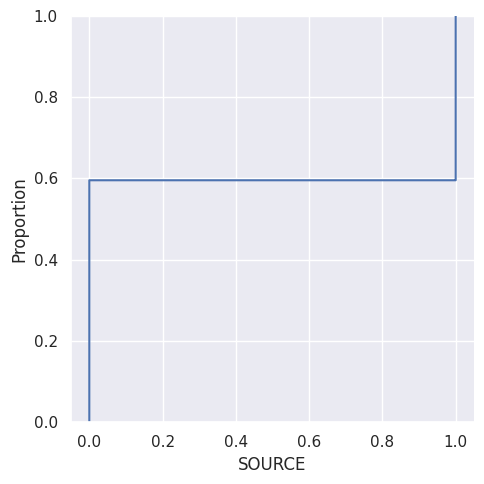

In [ ]:
sns.displot(data['SOURCE'], kind='ecdf', stat='proportion');

* The proportion of classes is about 60:40 which is only mildy imbalanced and won't greatly bias the classification

### Numerical Features

* HAEMATOCRIT
* HAEMOGLOBINS
* ERYTHROCYTE
* LEUCOCYTE
* THROMBOCYTE
* MCH
* MCHC
* MCV
* AGE

In [ ]:
data[num_feats].describe()

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE
count,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000,4412.000000
mean,38.197688,12.741727,4.541260,8.718608,257.524479,28.234701,33.343042,84.612942,46.626473
std,5.974784,2.079903,0.784091,5.049041,113.972365,2.672639,1.228664,6.859101,21.731218
min,13.700000,3.800000,1.480000,1.100000,8.000000,14.900000,26.000000,54.000000,1.000000
25%,34.375000,11.400000,4.040000,5.675000,188.000000,27.200000,32.700000,81.500000,29.000000
50%,38.600000,12.900000,4.570000,7.600000,256.000000,28.700000,33.400000,85.400000,47.000000
75%,42.500000,14.200000,5.050000,10.300000,321.000000,29.800000,34.100000,88.700000,64.000000
max,69.000000,18.900000,7.860000,76.600000,1183.000000,40.800000,39.000000,115.600000,99.000000


Based on the descriptions of each of the feature variables, a few peculiar values are in:
* **LEUCOCYTE** - max value is much higher than the mean value
* **THROMBOCYTE** - max and min values are very dispersed

In [ ]:
data.loc[data['LEUCOCYTE']==76.6]

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
3654,27.0,8.8,3.24,76.6,300,27.2,32.6,83.3,69,M,1


In [ ]:
data.loc[data['THROMBOCYTE']==1183]

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
3777,43.5,13.7,4.53,17.9,1183,30.2,31.5,96.0,71,F,0


* Most of the features follow an almost normal distribution with the exception of the LEUCOCYTE, THROMBOCYTE, and and AGE features.
* After inspecting the extreme values in 'LEUCOCYTE' and 'THROMBOCYTE' I have decided to keep them as the other values seem fine as this extreme values could be attributed to the reason they were visiting the hospital.

### Categorical Variable:

* **name**: SEX
* **classes**: F, M

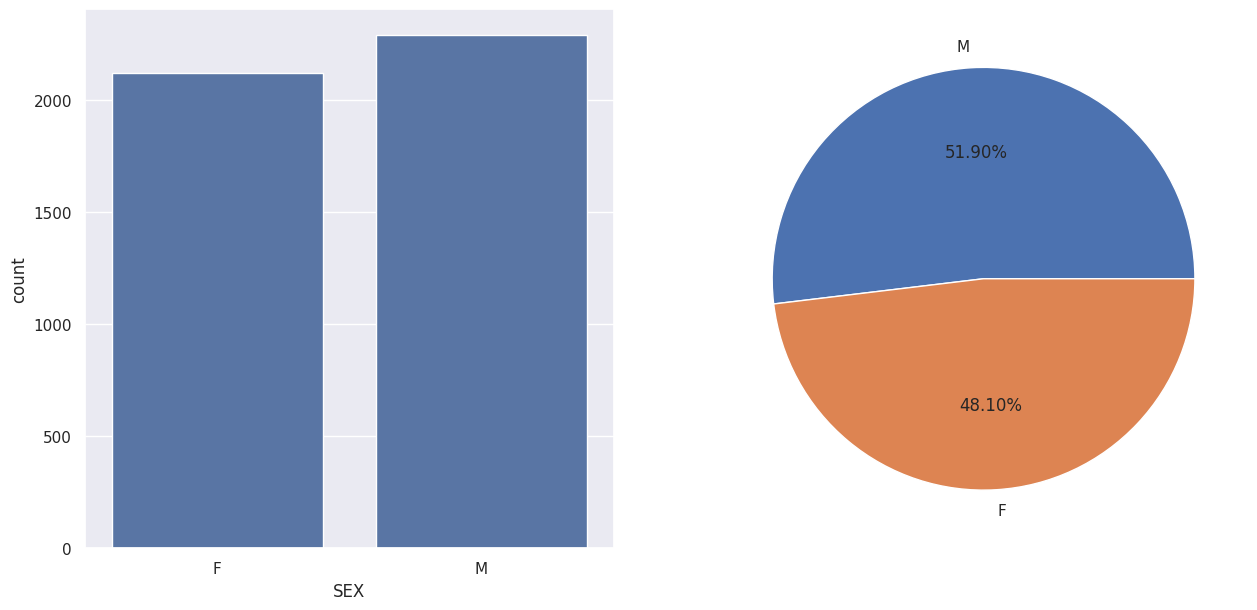

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
sns.countplot(data, x='SEX', ax=ax[0])
plt.pie(data['SEX'].value_counts(), autopct='%0.2f%%', labels=['M', 'F'])
plt.show();


In [ ]:
data['SEX'].value_counts()

M    2290
F    2122
Name: SEX, dtype: int64

### Bivariate Analysis:

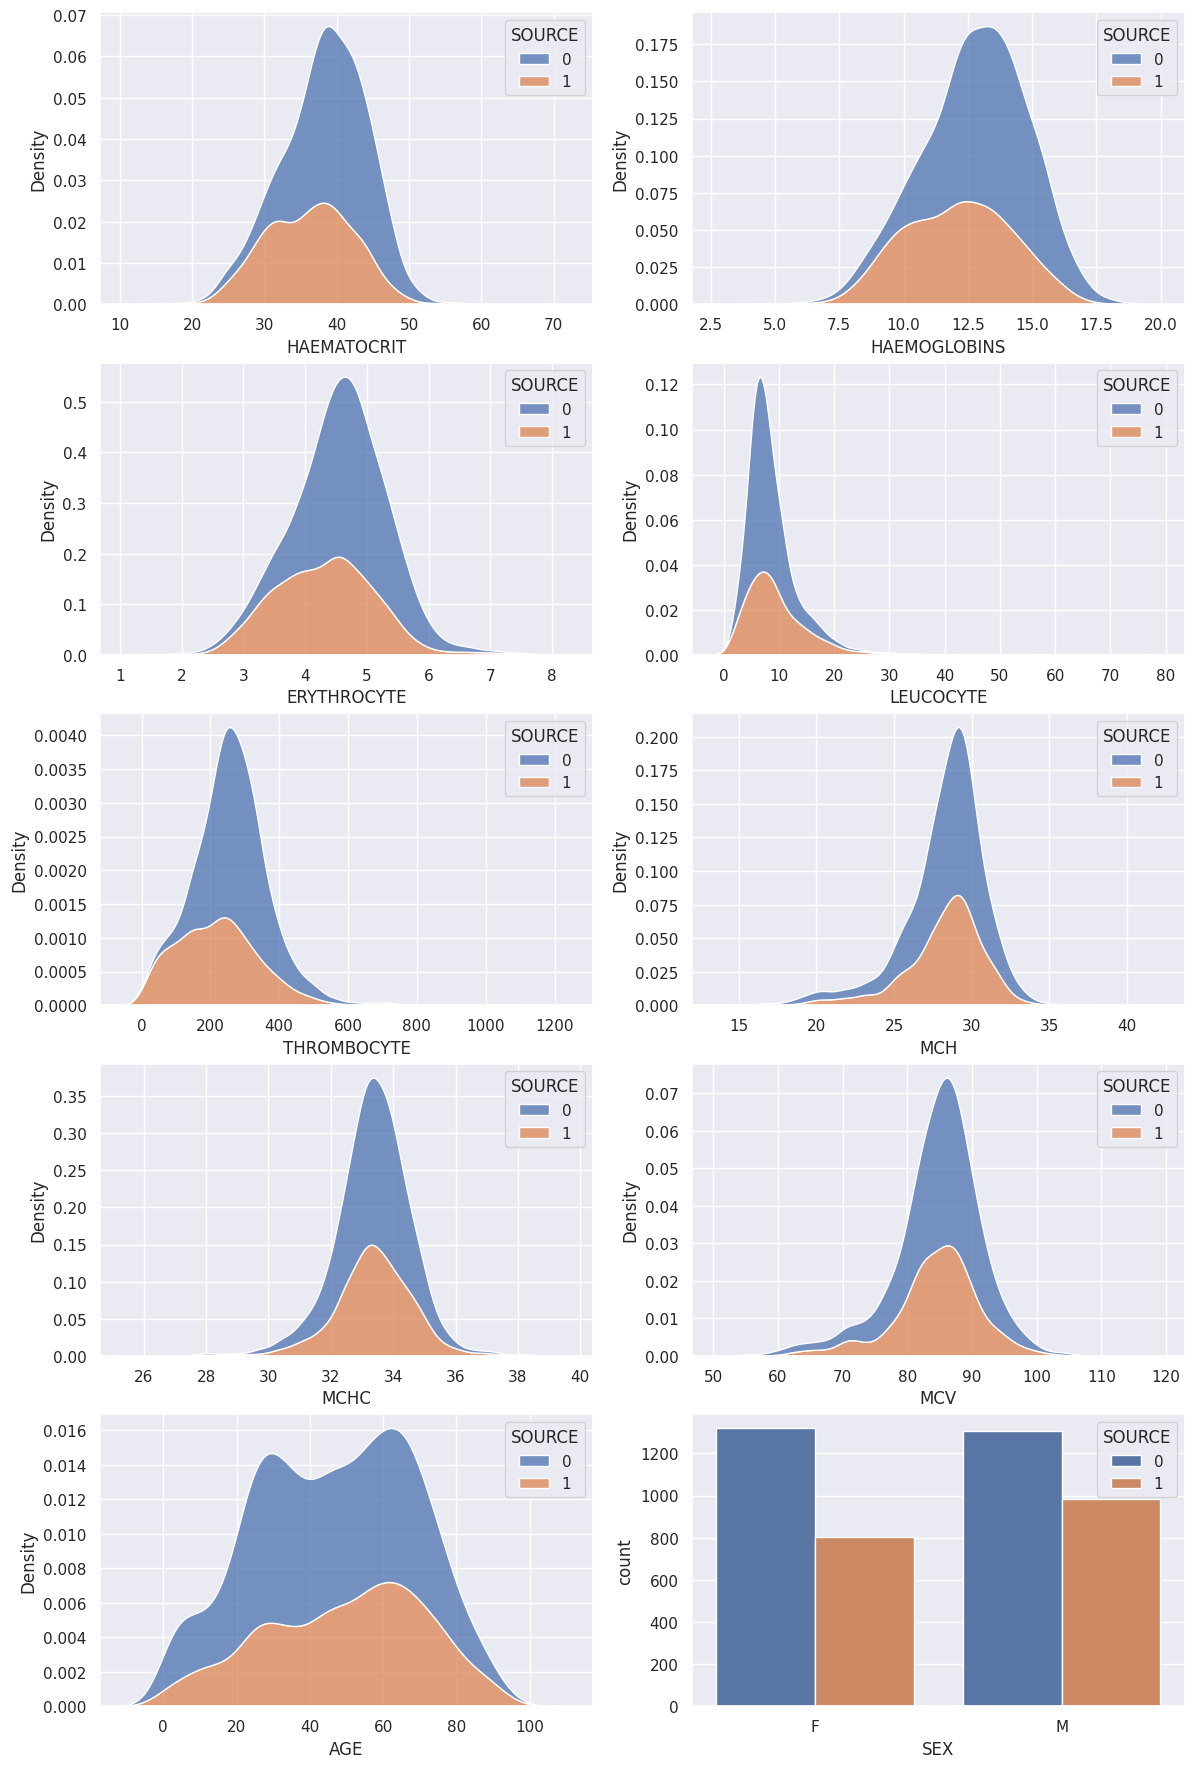

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(14,22))
axes = [ax for rows in axs for ax in rows]
for idx, feat in enumerate(data[num_feats]):
    plot = sns.kdeplot(data=data, x=feat, hue='SOURCE', multiple='stack', ax=axes[idx])
sns.countplot(data=data, x='SEX', hue='SOURCE', ax=axs[4,1]);

* The features HAEMATOCRIT, HAEMOGLOBINS, ERYTHROCYTE, THROMBOCYTE, AGE show quite a difference in their distributions between the 'in' and 'out' patients, indicating that they serve as much better differentiators of the target variables than the rest.

* The categorical variables only tell us that there is a slightly higher proportion of males in in-patients than out-patients.

* There is a slightly higher older population that are admitted as in-patients but that would be expected and is not of much an insight for now.

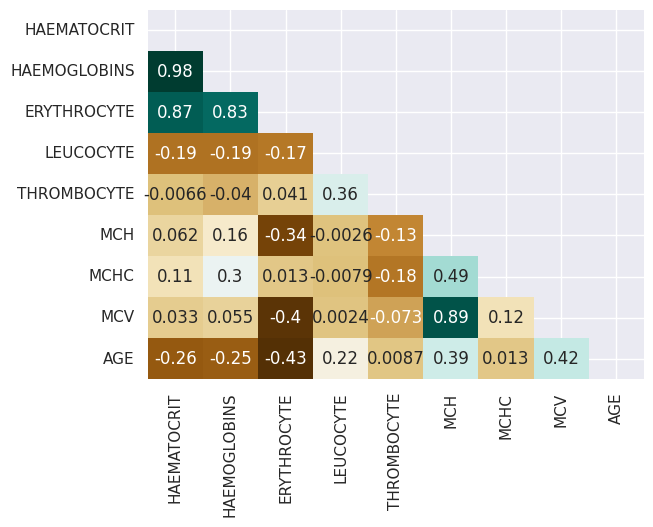

In [ ]:
corr = data[num_feats].corr(method='spearman')
triu_corr = np.triu(corr)
sns.heatmap(corr, annot=True, mask=triu_corr, cmap='BrBG', cbar=False)
plt.show();

* From the pairplots and correlation matrix we can see a high multicollinarity between  'HAEMATOCRIT' and 'HAEMOGLOBINS'(0.98) and  'MCH' and 'MCHC' (0.89). Even 'HAEMATOCRIT' and 'ERYTHROCYTE' (0.87), 'HAEMOGLOBINS' and  'ERYTHROCYTE' (0.83) have a relatively high level of correlation that can lead to overfitting of the model and lead to poor generalization performance on unseen data.

---
## Feature Engineering:

In [ ]:
## Train test split

# Feature set
X = data[features]
# Target set
y = data['SOURCE']

# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# train and test datasets dimensions
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3529, 10), (883, 10), (3529,), (883,))

In [ ]:
# Label Encding

# Encode binary classes for the 'M' and 'F' categorical values

X_train.SEX.replace({'F':0, 'M': 1}, inplace=True)
X_test.SEX.replace({'F':0, 'M': 1}, inplace=True)



In [ ]:
# Feature Scaling

# Based on the distribution and outliers observed in the univariate analysis we can resort to
# using a MinMaxScaler from sklearn

# minmax = MinMaxScaler(feature_range=(0,1))
scaler = MinMaxScaler(feature_range=(0,1))

X_train[num_feats] = scaler.fit_transform(X_train[num_feats]) #fit and transform the train set
X_test[num_feats] = scaler.transform(X_test[num_feats]) #transform the test test

###  Feature Selection

In [ ]:
#Columns dropped based on correlation of data that would render the feature values redundant

X_train.drop(['HAEMATOCRIT','MCH'], axis=1, inplace=True)
X_test.drop(['HAEMATOCRIT','MCH'], axis=1, inplace=True)


---
## Model Building

### 1. Logistic Regression:

The basis for choosing logistic regression is mainly given the fact that the target variable is binary in nature and we can use the logistic regression as a base model to compare with the other models.

In [ ]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

print("Train accuracy : ", accuracy_score(y_train, logreg.predict(X_train)))
print("Test accuracy : ", accuracy_score(y_test, logreg.predict(X_test)))

Train accuracy :  0.7180504392179088
Test accuracy :  0.6987542468856173


# Hyper-parameter tuning for Logistic Regression

In [ ]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'penalty':['l1', 'l2', 'elasticnet', 'none'],
              'fit_intercept':[True, False],
              'max_iter':[100, 200, 300],
              'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 4}, {0: 1, 1: 5}]
             }

# Random search for best hyperparameters
search = RandomizedSearchCV(LogisticRegression(random_state=1),
                         param_grid,
                         scoring='accuracy',
                         cv=3,
                         verbose=1,
                         random_state=1,
                         n_iter=30)

search.fit(X_train, y_train)

# Best parameters for Logistic regression classifier
search.best_params_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


{'penalty': 'none',
 'max_iter': 300,
 'fit_intercept': True,
 'class_weight': {0: 1, 1: 1},
 'C': 0.01}

In [ ]:
best_logreg = search.best_estimator_

best_logreg.fit(X_train, y_train)
print("Best train accuracy : ", accuracy_score(y_train, best_logreg.predict(X_train)))
print("Best test accuracy : ", accuracy_score(y_test, best_logreg.predict(X_test)))

Best train accuracy :  0.7322187588551998
Best test accuracy :  0.7089467723669309


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, best_logreg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.71      0.85      0.78       526
           1       0.70      0.50      0.58       357

    accuracy                           0.71       883
   macro avg       0.70      0.68      0.68       883
weighted avg       0.71      0.71      0.70       883



### 2. Support Vector Machine:

In [ ]:
svc = SVC(random_state=1)

svc.fit(X_train, y_train)

print("Train accuracy : ", accuracy_score(y_train, svc.predict(X_train)))
print("Test accuracy : ", accuracy_score(y_test, svc.predict(X_test)))

Train accuracy :  0.7588551997733068
Test accuracy :  0.72480181200453


# Hyper-parameter tuning for SVM

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear', 'rbf', 'poly'],
              'degree':[0, 1, 2, 3, 4, 5, 6]
             }

# Random search for best hyperparameters
search = RandomizedSearchCV(SVC(random_state=1),
                         param_grid,
                         scoring='accuracy',
                         cv=3,
                         verbose=1,
                         random_state=1,
                         n_iter=30)

search.fit(X_train, y_train)

# Best parameters for Support vector classifier
search.best_params_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


{'kernel': 'rbf', 'gamma': 1, 'degree': 4, 'C': 100}

In [ ]:
best_svc = search.best_estimator_

best_svc.fit(X_train, y_train)
print("Best train accuracy : ", accuracy_score(y_train, best_svc.predict(X_train)))
print("Best test accuracy : ", accuracy_score(y_test, best_svc.predict(X_test)))

Best train accuracy :  0.7716066874468688
Best test accuracy :  0.7440543601359003


In [ ]:
print(classification_report(y_test, best_svc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.75      0.86      0.80       526
           1       0.74      0.57      0.64       357

    accuracy                           0.74       883
   macro avg       0.74      0.72      0.72       883
weighted avg       0.74      0.74      0.74       883



### 3. Random Forest:

In [ ]:
forest = RandomForestClassifier(random_state=1)

forest.fit(X_train, y_train)

print("Train accuracy : ", accuracy_score(y_train, forest.predict(X_train)))
print("Test accuracy : ", accuracy_score(y_test, forest.predict(X_test)))

Train accuracy :  1.0
Test accuracy :  0.7519818799546999


# Hyper-Parameter tuning for Random Forest

In [ ]:
params_grid = {'bootstrap': [True, False],
             'max_depth': [2, 5, 10, 20, None],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 2, 4],
             'min_samples_split': [2, 5, 10],
             'n_estimators': [50, 100, 150, 200]}

# Random search for best hyperparameters
search = RandomizedSearchCV(RandomForestClassifier(random_state=1),
                         params_grid,
                         scoring='accuracy',
                         cv=3,
                         verbose=1,
                         random_state=1,
                         n_iter=20)

search.fit(X_train, y_train)

# Best parameters for Random forest classifier
search.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': False}

In [ ]:
best_forest = search.best_estimator_

best_forest.fit(X_train, y_train)
print("Best train accuracy : ", accuracy_score(y_train, best_forest.predict(X_train)))
print("Best test accuracy : ", accuracy_score(y_test, best_forest.predict(X_test)))

Best train accuracy :  0.8999716633607254
Best test accuracy :  0.7451868629671574


In [ ]:
print(classification_report(y_test, best_forest.predict(X_test)))

              precision    recall  f1-score   support

           0       0.75      0.85      0.80       526
           1       0.73      0.59      0.65       357

    accuracy                           0.75       883
   macro avg       0.74      0.72      0.73       883
weighted avg       0.74      0.75      0.74       883



### 4. Decision Tree Classifier

In [ ]:
tree = DecisionTreeClassifier(random_state=1)
tree.fit(X_train, y_train)

print("Train accuracy : ", accuracy_score(y_train, tree.predict(X_train)))
print("Test accuracy : ", accuracy_score(y_test, tree.predict(X_test)))

Train accuracy :  1.0
Test accuracy :  0.6670441676104191


# Hyperparameter tuning of Decision tree classifier

In [ ]:
# Hyperparameters
distribution = {'max_depth': [4, 6, 8, 10, 12, 14, 16],
                'criterion': ['gini', 'entropy'],
                'min_samples_split': [2, 10, 20, 30, 40],
                'max_features': [0.2, 0.4, 0.6, 0.8, 1],
                'max_leaf_nodes': [8, 16, 32, 64, 128,256],
                'class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}]
               }

# Random search for best hyperparameters
search = RandomizedSearchCV(DecisionTreeClassifier(random_state=1),
                         distribution,
                         scoring='accuracy',
                         cv=3,
                         verbose=1,
                         random_state=1,
                         n_iter=30)

search.fit(X_train, y_train)

# Best parameters for DT classifier
search.best_params_


Fitting 3 folds for each of 30 candidates, totalling 90 fits


{'min_samples_split': 2,
 'max_leaf_nodes': 8,
 'max_features': 0.6,
 'max_depth': 4,
 'criterion': 'entropy',
 'class_weight': {0: 1, 1: 2}}

In [ ]:
best_tree = search.best_estimator_

best_tree.fit(X_train, y_train)
print(" Best train accuracy : ", accuracy_score(y_train, best_tree.predict(X_train)))
print(" Best test accuracy : ", accuracy_score(y_test, best_tree.predict(X_test)))

 Best train accuracy :  0.698781524511193
 Best test accuracy :  0.6636466591166478


In [ ]:
print(classification_report(y_test, best_tree.predict(X_test)))

              precision    recall  f1-score   support

           0       0.76      0.64      0.69       526
           1       0.57      0.70      0.63       357

    accuracy                           0.66       883
   macro avg       0.66      0.67      0.66       883
weighted avg       0.68      0.66      0.67       883



---
## Results

In [ ]:
# Create a function to plot confusion matrix and classification metrics
def plot_cm(cm, precision, recall, f2score, accuracy, title):
    plt.figure(figsize=(10,5))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'viridis');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');

    plt.subplot(1, 2, 2)
    metrics = [precision, recall, f2score, accuracy]
    metric_names = ['Precision', 'Recall', 'F2 Score', 'Accuracy']
    sns.barplot(x=metric_names, y=metrics, palette = sns.color_palette("husl", 9))
    plt.ylim(0, 1)

    plt.suptitle(title, size = 15)


In [ ]:
svm_precision_opt, svm_recall_opt, svm_f2score_opt, svm_support_opt = precision_recall_fscore_support(y_test, best_svc.predict(X_test), beta=2)
svm_accuracy_opt = accuracy_score(y_test, best_svc.predict(X_test))

random_forest_precision_opt, random_forest_recall_opt, random_forest_f2score_opt, random_forest_support_opt = precision_recall_fscore_support(y_test, best_forest.predict(X_test), beta=2)
random_forest_accuracy_opt = accuracy_score(y_test, best_forest.predict(X_test))

logreg_precision_opt, logreg_recall_opt, logreg_f2score_opt, logreg_support_opt = precision_recall_fscore_support(y_test, best_logreg.predict(X_test), beta=2)
logreg_accuracy_opt = accuracy_score(y_test, best_logreg.predict(X_test))

tree_precision_opt, tree_recall_opt, tree_f2score_opt, tree_support_opt = precision_recall_fscore_support(y_test, best_tree.predict(X_test), beta=2)
tree_accuracy_opt = accuracy_score(y_test, best_tree.predict(X_test))

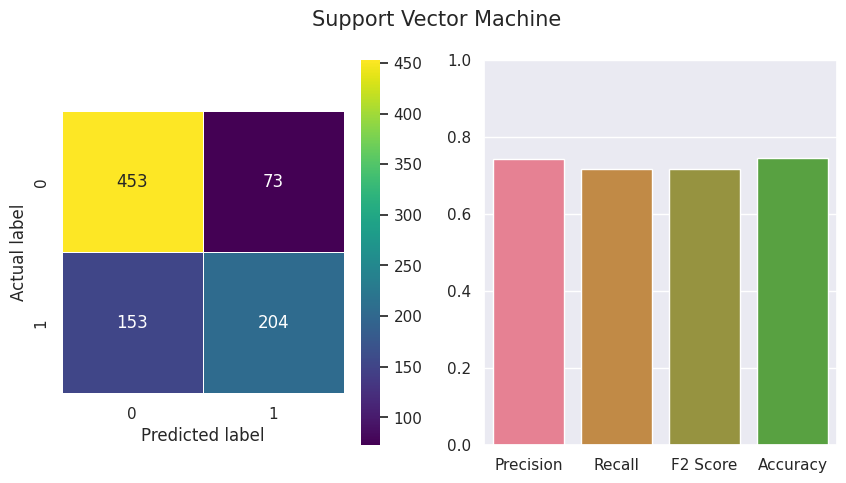

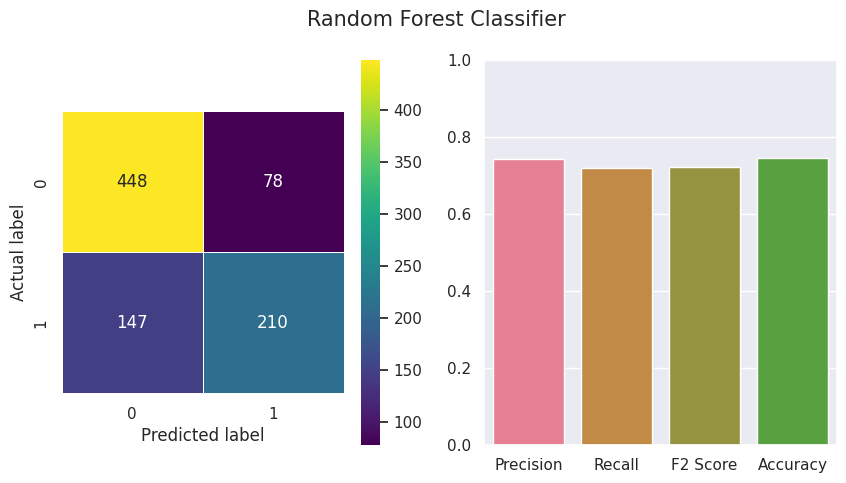

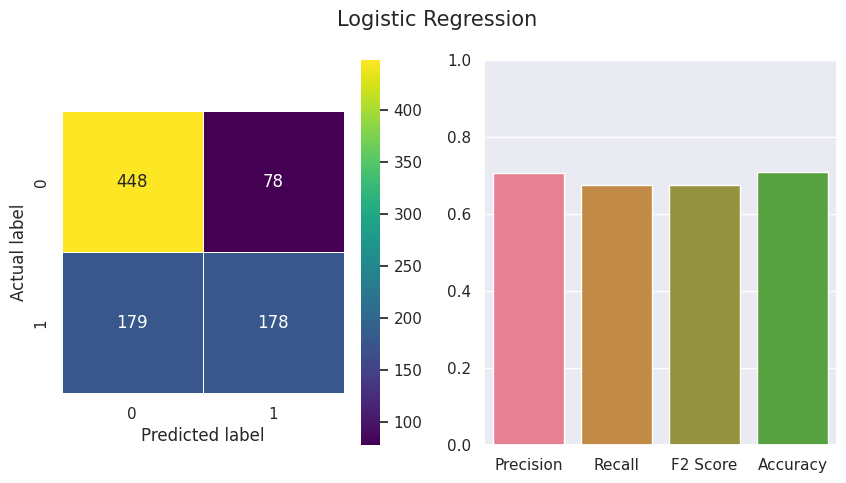

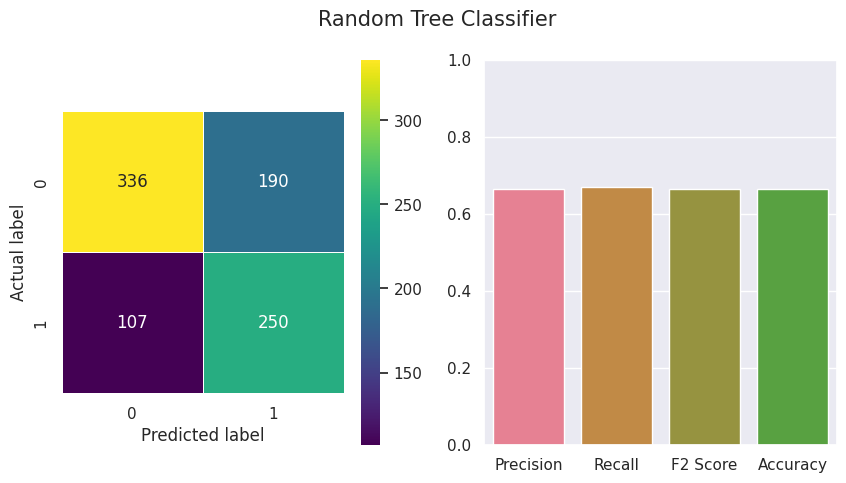

In [ ]:
# Compute average metrics
svm_precision_opt_avg = np.mean(svm_precision_opt)
svm_recall_opt_avg = np.mean(svm_recall_opt)
svm_f2score_opt_avg = np.mean(svm_f2score_opt)


random_forest_precision_opt_avg = np.mean(random_forest_precision_opt)
random_forest_recall_opt_avg = np.mean(random_forest_recall_opt)
random_forest_f2score_opt_avg = np.mean(random_forest_f2score_opt)

logreg_precision_opt_avg = np.mean(logreg_precision_opt)
logreg_recall_opt_avg = np.mean(logreg_recall_opt)
logreg_f2score_opt_avg = np.mean(logreg_f2score_opt)

tree_precision_opt_avg = np.mean(tree_precision_opt)
tree_recall_opt_avg = np.mean(tree_recall_opt)
tree_f2score_opt_avg = np.mean(tree_f2score_opt)

# Compute confusion matrices
cm_svm = confusion_matrix(y_test, best_svc.predict(X_test))
cm_rf = confusion_matrix(y_test, best_forest.predict(X_test))
cm_logreg = confusion_matrix(y_test, best_logreg.predict(X_test))
cm_tree = confusion_matrix(y_test, best_tree.predict(X_test))


# Plot confusion matrices and classification metrics
plot_cm(cm_svm, svm_precision_opt_avg, svm_recall_opt_avg, svm_f2score_opt_avg, svm_accuracy_opt, 'Support Vector Machine')
plot_cm(cm_rf, random_forest_precision_opt_avg, random_forest_recall_opt_avg, random_forest_f2score_opt_avg, random_forest_accuracy_opt, 'Random Forest Classifier')
plot_cm(cm_logreg, logreg_precision_opt_avg, logreg_recall_opt_avg, logreg_f2score_opt_avg, logreg_accuracy_opt, 'Logistic Regression')
plot_cm(cm_tree, tree_precision_opt_avg, tree_recall_opt_avg, tree_f2score_opt_avg, tree_accuracy_opt, 'Random Tree Classifier')


In [ ]:
from sklearn.ensemble import StackingClassifier

import pickle

In [ ]:
features = ['HAEMATOCRIT', 'HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE','THROMBOCYTE', 'AGE', 'SEX']
num_features = ['HAEMATOCRIT', 'HAEMOGLOBINS', 'ERYTHROCYTE', 'LEUCOCYTE','THROMBOCYTE', 'AGE']

X = data[features] # feature set
y = data['SOURCE'] # target

# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Label encoding
X_train.SEX.replace({'M':1, 'F':0}, inplace=True)
X_test.SEX.replace({'M':1, 'F':0}, inplace=True)

# Feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))

X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

model = model = StackingClassifier(estimators=[('best tree classifier', best_tree),
                                       ('best logreg', best_logreg),
                                       ('best svc', best_svc),
                                       ('best forest classifier', best_forest),], final_estimator=LogisticRegression(), passthrough=True)

model.fit(X_train, y_train)
with open("scaler.pkl", 'wb') as file:
    pickle.dump(scaler, file)

with open("model.pkl", 'wb') as file:
    pickle.dump(model, file)